# Using Galaxy Magnitudes to Estimate Photometric Redshifts

This notebook covers the basics of using real galaxy magnitudes to estimate photometric redshifts with RAIL. We will use a couple of the RAIL algorithms to do this, to get a sense of the differences between algorithms and how they work. We'll go through the following steps:

1. Setting up training and testing data sets 
2. Estimating redshifts with `k-Nearest Neighbours` (KNN)
3. Estimating redshifts with `FlexZBoost`


Before we get started, here's a quick introduction to some of the features of RAIL interactive mode. The only RAIL package you need to import is the `rail.interactive` package. This contains all of the interactive functions for all of the RAIL algorithms. You may need to import supporting functions that are not part of a stage separately. To get a sense of what functions/stages are available and for some more detailed instructions, see [the RAIL documentation](https://descraildocs.z27.web.core.windows.net/source/user_guide/interactive_usage.html).  

In [1]:
# import the packages we'll need 
import rail.interactive as ri 

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


LEPHAREDIR is being set to the default cache directory:
/home/jscora/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/jscora/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/jscora/.cache/lephare/runs/20250327T165906


In this notebook, we'll be using estimation algorithms, which can all be found under the `ri.estimation.algos` namespace. You can see a list of existing algorithms (here), or you can also explore the available options using tab-complete. Each algorithm will have its own namespace, for example, the namespace for KNN is `k_nearneigh`. Each of these algorithms will then have an `informer` and `estimator` method.

To get the docstrings for a function, including what parameters it needs and what it returns, you can just put a question mark after the function call or use the `help()` function, as you would with any python function. For example, we'll be using the KNN estimator function later, so we can take a look at what it needs:

In [2]:
ri.estimation.algos.k_nearneigh.k_near_neigh_estimator?

Signature:       ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(**kwargs) -> Any
Call signature:  ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x7fa53f468c20>, <class 'rail.estimation.algos.k_nearneigh.KNearNeighEstimator'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
KNN-based estimator

---

The main interface method for the photo-z estimation

This will attach the input data (defined in ``inputs`` as "input") to this
``Estimator`` (for introspection and provenance tracking). Then call the
``run()``, ``validate()``, and ``finalize()`` methods.

The run method will call ``_process_chunk()``, which needs to be implemented
in the subclass, to process input data in batches. See ``RandomGaussEstimator``
for a simple example.

Finally, this will return a ``QPHandle`` for access to that output data.

--

## 1. Setting up training and testing data sets

In this notebook we'll be using the ['Estimation' stage](https://descraildocs.z27.web.core.windows.net/source/rail_stages/estimation.html) of RAIL. The estimation algorithms, or `Estimators`, have both an *inform* method and an *estimation* method. The inform method trains the model that will be used to estimate the redshifts, so that will need to be given both magnitude data and the true redshifts of the galaxies. We can then pass a new set of magnitudes (the ones we're actually interested in) to the *estimator*, along with the model that the informer created. The estimator can then apply the model to the new magnitudes in order to calculate a redshift value. 

This means we'll need two separate data sets for each of the methods. We'll start by getting those data sets set up. `test_dc2_training_9816.hdf5` is what we'll use for training the *inform* method, and `test_dc2_validation_9816.hdf5` will act as our 'real' galaxy magnitude data, which we will provide to the *estimation* method to get our photometric redshifts (photo-z). Both files contain data drawn from the cosmoDC2_v1.1.4 truth extragalactic catalog generated by DESC with model 10-year-depth magnitude uncertainties.  The training data contains roughly 10,000 galaxies, while the test data contains roughly 20,000.  Both sets are representative down to a limiting apparent magnitude. 

First, we'll use the `find_rail_file` function to get the full path to the data files mentioned above. If you have your own data, you can substitute in the path to that file for the value of `testFile` below. 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tables_io
from rail.utils.path_utils import find_rail_file

trainFile = find_rail_file("examples_data/testdata/test_dc2_training_9816.hdf5")
testFile = find_rail_file("examples_data/testdata/test_dc2_validation_9816.hdf5")
print(trainFile)

/home/jscora/code/desc-rail/rail_base/src/rail/examples_data/testdata/test_dc2_training_9816.hdf5


Now let's read these files in. We'll start by reading in the training data, and converting it to a Pandas dataframe to make it easier to read:

In [4]:
# read in file 
training_data = tables_io.read(trainFile)
print(type(training_data), training_data.keys())

# get the data table out of the photometry dictionary and convert to pandas DataFrame
training_data = training_data["photometry"]
training_data = tables_io.convert(training_data, "pandasDataFrame")
print(training_data.info())

<class 'collections.OrderedDict'> odict_keys(['photometry'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10225 entries, 0 to 10224
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10225 non-null  int64  
 1   mag_err_g_lsst  10225 non-null  float32
 2   mag_err_i_lsst  10225 non-null  float32
 3   mag_err_r_lsst  10225 non-null  float32
 4   mag_err_u_lsst  10225 non-null  float32
 5   mag_err_y_lsst  10225 non-null  float32
 6   mag_err_z_lsst  10225 non-null  float32
 7   mag_g_lsst      10225 non-null  float32
 8   mag_i_lsst      10225 non-null  float32
 9   mag_r_lsst      10225 non-null  float32
 10  mag_u_lsst      10225 non-null  float32
 11  mag_y_lsst      10225 non-null  float32
 12  mag_z_lsst      10225 non-null  float32
 13  redshift        10225 non-null  float64
dtypes: float32(12), float64(1), int64(1)
memory usage: 639.2 KB
None


`training_data` is now a Pandas DataFrame, containing information on 10,225 galaxies. It has magnitude information for the *ugrizy* bands, including errors, and the true redshift of these galaxies.

We'll now also load in the test data, which contains the magnitudes for the galaxies we actually want to calculate redshifts for. Just as an example, we'll leave the test data in the default format given by `tables_io` for an `hdf5` file, which is a dictionary of arrays. Either method can be used with RAIL functions, but they can require slightly different methods of passing the data.

In [5]:
test_data = tables_io.read(testFile)
print(test_data["photometry"].keys())

odict_keys(['id', 'mag_err_g_lsst', 'mag_err_i_lsst', 'mag_err_r_lsst', 'mag_err_u_lsst', 'mag_err_y_lsst', 'mag_err_z_lsst', 'mag_g_lsst', 'mag_i_lsst', 'mag_r_lsst', 'mag_u_lsst', 'mag_y_lsst', 'mag_z_lsst', 'redshift'])


## 2. Estimate redshifts with the [KNN algorithm](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) 

**The algorithm**:  The `k-Nearest Neighbours` algorithm we're using (see [here](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for more of an explanation of how it works) is a wrapper around `sklearn`'s nearest neighbour (NN) machine learning model. Essentially, it takes a given galaxy, identifies its nearest neighbours in the space, in this case galaxies that have similar colours, and then constructs the photometric redshift PDF as a sum of Gaussians from each neighbour.

**Inform**: The inform method is training the model that we will use to estimate the redshifts. It will set aside some of the training data set as a validation data set. We will plug in our training data set, and any parameters the model needs, which we can check by putting a question mark after the function name:


In [6]:
ri.estimation.algos.k_nearneigh.k_near_neigh_informer?

Signature:       ri.estimation.algos.k_nearneigh.k_near_neigh_informer(**kwargs) -> Any
Call signature:  ri.estimation.algos.k_nearneigh.k_near_neigh_informer(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x7fa53f468c20>, <class 'rail.estimation.algos.k_nearneigh.KNearNeighInformer'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
Train a KNN-based estimator

---

The main interface method for Informers

This will attach the input_data to this `Informer`
(for introspection and provenance tracking).

Then it will call the run(), validate() and finalize() methods, which need to
be implemented by the sub-classes.

The run() method will need to register the model that it creates to this Estimator
by using `self.add_data('model', model)`.

Finally, this will return a ModelHandle providing access to the trained model.

---

This function was generated from the function


There are a lot of optional parameters. Some of the main ones to be aware of for the KNN algorithm are:
- `trainfrac` sets the proportion of training data to use in training the algorithm, where the remaining fraction is used to validate both the width of the Gaussians used in constructing the PDF and the number of neighbors used in each PDF.  
- `sigma_grid_min`, `sigma_grid_max`, and `ngrid_sigma` are used to specify the grid of sigma values to test for the Gaussians 
- `nneigh_min` and `nneigh_max` set the range of nearest neighbours that will be tested 
- `zmin`, `zmax`, and `nzbins` are used to create a grid of redshift points on which to validate the model 

The only required parameter is the training data (called `input`). We'll also need to include `hdf5_groupname = ""`, since we've pulled the data table out of the `photometry` group when we converted to a DataFrame:

In [7]:
knn_dict = dict(
    zmin=0.0,
    zmax=3.0,
    nzbins=301,
    trainfrac=0.75,
    sigma_grid_min=0.01,
    sigma_grid_max=0.07,
    ngrid_sigma=10,
    nneigh_min=3,
    nneigh_max=7,
    hdf5_groupname="",
)
knn_inform = ri.estimation.algos.k_nearneigh.k_near_neigh_informer(input=training_data, **knn_dict)
print(knn_inform)

Inserting handle into data store.  input: None, KNearNeighInformer
split into 7669 training and 2556 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.023333333333333334 and numneigh=7



Inserting handle into data store.  model: inprogress_model.pkl, KNearNeighInformer
{'model': {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x60e0b5c2d080>, 'bestsig': np.float64(0.023333333333333334), 'nneigh': 7, 'truezs': array([0.02043499, 0.01936132, 0.03672067, ..., 2.97927326, 2.98694714,
       2.97646626], shape=(10225,)), 'only_colors': False}}


### Saving a model and using it with an estimator stage
We can see that the output of the inform stage is a dictionary with the model under the "model" key. To make our lives easier, we can save this model to a file. That way, we only have to run the `estimator` method in the future, and supply the file name of the model we've just saved. This will speed up our data analysis. Let's start by saving the file:


In [8]:
import pickle

# write model file out here
with open("./knn_model.pkl", "wb") as fout:
        pickle.dump(obj=knn_inform["model"], file=fout, protocol=pickle.HIGHEST_PROTOCOL)

**Estimate**: Now that our model is trained, we can use it to estimate the redshifts of the test data set. We provide the estimate algorithm with the test data set, and the filename of the model that we've trained, and any other necessary parameters:

In [9]:
knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(input=test_data,model="knn_model.pkl")

Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: knn_model.pkl, KNearNeighEstimator
Process 0 running estimator on chunk 0 - 20,449
Process 0 estimating PZ PDF for rows 0 - 20,449
Inserting handle into data store.  output: inprogress_output.hdf5, KNearNeighEstimator


Now let's take a look at what the output of the estimation stage actually looks like. Most estimation stages output an `Ensemble`, which is a data structure from the package `qp`. For more information, see [the documentation](https://qp.readthedocs.io/en/main/user_guide/datastructure.html). 

We're using an `Ensemble` to hold a redshift distribution for each of the galaxies we're estimating. There are two required dictionaries that make up an Ensemble, and one that is optional:
- `.metadata`: Contains information about the whole data structure, like the Ensemble type, and any shared parameters such as the bins of histograms. This is not per-object metadata. 
- `.objdata`: The main data points of the distributions for each object, where each object is a row. 
- `.ancil`: the optional dictionary, containing extra information about each object. It can have arrays that have one or more data points per distribution. Typically the ancillary data table includes a photo-z point estimate derived from the PDFs, the mode by default, called 'zmode' in the ancillary dictionary below:

In [10]:
knn_estimated

{'output': Ensemble(the_class=mixmod,shape=(20449, 7))}

We can see that this algorithm outputs Ensembles of class `mixmod`, which are just combinations of Gaussians (for more info see the [docs](https://qp.readthedocs.io/en/main/user_guide/parameterizations/mixmod.html)). The shape portion of the print statement tells us two things: the first number is the number of photo-z distributions, or galaxies, in this `Ensemble`, and the second number tells us how many Gaussians are combined to make up each photo-z distribution. 

Let's take a look at what the different dictionaries look like for this `Ensemble`:  

In [11]:
print(knn_estimated["output"].metadata)

{'pdf_name': array([b'mixmod'], dtype='|S6'), 'pdf_version': array([0])}


In [12]:
print(knn_estimated["output"].objdata)

{'weights': array([[0.19366908, 0.1634485 , 0.16324174, ..., 0.12108914, 0.11136012,
        0.11134809],
       [0.26940903, 0.19196925, 0.11705012, ..., 0.10745789, 0.1025761 ,
        0.09628477],
       [0.19355378, 0.17701762, 0.15944133, ..., 0.12632037, 0.1150918 ,
        0.09227033],
       ...,
       [0.20843019, 0.17281054, 0.13567747, ..., 0.12303307, 0.11875043,
        0.11566106],
       [0.22362229, 0.14954008, 0.13867478, ..., 0.12340792, 0.11824944,
        0.11771897],
       [0.18216124, 0.15785531, 0.13410361, ..., 0.13205696, 0.1308656 ,
        0.12984857]], shape=(20449, 7)), 'stds': array([[0.02333333, 0.02333333, 0.02333333, ..., 0.02333333, 0.02333333,
        0.02333333],
       [0.02333333, 0.02333333, 0.02333333, ..., 0.02333333, 0.02333333,
        0.02333333],
       [0.02333333, 0.02333333, 0.02333333, ..., 0.02333333, 0.02333333,
        0.02333333],
       ...,
       [0.02333333, 0.02333333, 0.02333333, ..., 0.02333333, 0.02333333,
        0.0233333

In [13]:
print(knn_estimated["output"].ancil)

{'zmode': array([[0.06],
       [0.14],
       [0.08],
       ...,
       [2.98],
       [2.97],
       [0.18]], shape=(20449, 1)), 'redshift': array([0.02304609, 0.02187623, 0.0441931 , ..., 3.0210144 , 2.98104019,
       2.95916868], shape=(20449,)), 'distribution_type': array([0, 0, 0, ..., 0, 0, 0], shape=(20449,))}


We can also get a slice of distributions or a single specific distribution by slicing the Ensemble, for example: `knn_estimated["output"][0]` would give us the first distribution. 

Now we can take a look at what these photo-z distributions actually look like by plotting them. You can use the `.plot_native` method to do this quickly, but if you want to make your own plots you can use the `.pdf` function which takes an array of redshift values and returns the photo-z probability distribution function at those values, like this:

Text(0, 0.5, 'p(z)')

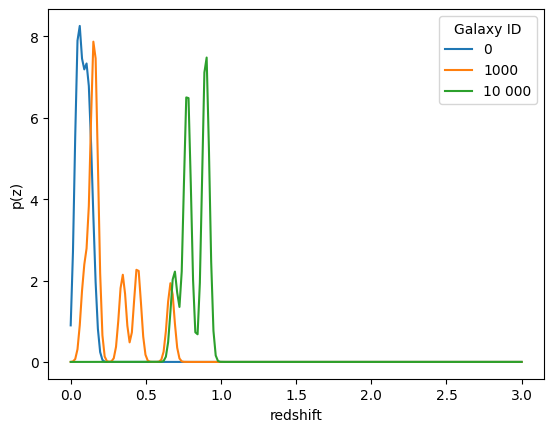

In [14]:
import matplotlib.pyplot as plt 
%matplotlib inline 

xvals = np.linspace(0,3,200) # we want to cover the whole available redshift space
plt.plot(xvals, knn_estimated["output"][0].pdf(xvals),label="0") 
plt.plot(xvals, knn_estimated["output"][1000].pdf(xvals),label="1000")
plt.plot(xvals, knn_estimated["output"][10000].pdf(xvals),label="10 000")

plt.legend(loc="best", title="Galaxy ID")
plt.xlabel("redshift")
plt.ylabel("p(z)")

We can see that these distributions have varying shapes. To get a point estimate of the redshift, we can use the `zmode` value from the ancillary dictionary. Also, for this notebook our test data has real redshifts to compare against. Let's take the 1000th galaxy's distribution and compare it to these two values:

Text(0, 0.5, 'p(z)')

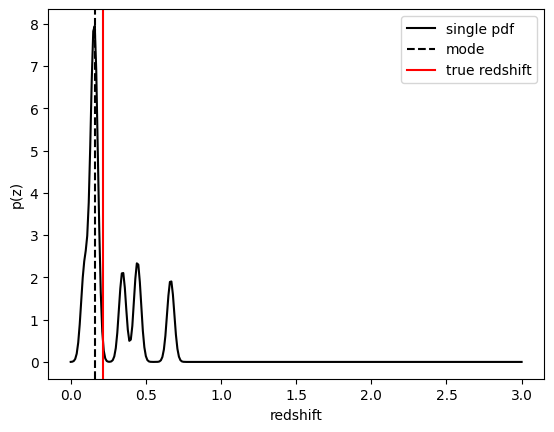

In [15]:
zgrid = np.linspace(0, 3.0, 301)
galid = 1000
truez = test_data["photometry"]["redshift"][galid]
single_gal = np.squeeze(knn_estimated["output"][galid].pdf(zgrid))
single_zmode = knn_estimated["output"].ancil["zmode"][galid]

plt.plot(zgrid, single_gal, color="k", label="single pdf")
plt.axvline(single_zmode, color="k", ls="--", label="mode")
plt.axvline(truez, color="r", label="true redshift")
plt.legend(loc="upper right")
plt.xlabel("redshift")
plt.ylabel("p(z)")

We can see there is some difference between the true redshift and the estimated redshift point estimate, though for this galaxy the point estimate seems quite good. Let's see how the algorithm did overall by plotting the redshift point estimates (the "zmodes") versus the true redshifts:

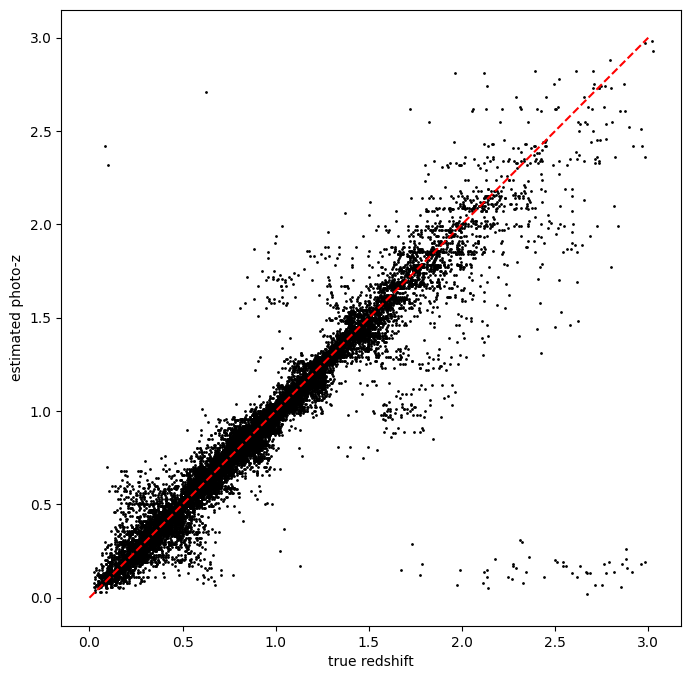

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(
    test_data["photometry"]["redshift"],
    knn_estimated["output"].ancil["zmode"].flatten(),
    s=1,
    c="k",
    label="simple NN mode",
)
plt.plot([0, 3], [0, 3], "r--")
plt.xlabel("true redshift")
plt.ylabel("estimated photo-z")
plt.show()

We can see that the algorithm does quite well overall, though there are certainly some outliers, and more of a spread at higher redshifts. 

## 3. Estimate redshifts with [FlexZBoost](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#flexzboost)

Now let's use `FlexZBoost` to get our redshifts. `FlexZBoostEstimator` approximates the conditional density estimate for each PDF with a set of weights on a set of basis functions.  This can save space relative to a gridded parameterization, but it also leads to residual "bumps" in the PDF intrinsic to the underlying cosine or fourier parameterization.  For this reason, `FlexZBoostEstimator` has a post-processing stage where it "trims" (i.e. sets to zero) any small peaks, or "bumps", below a certain `bump_thresh` threshold. For more details on running `FlexZBoost`, see the 'Quick_Start_in_Estimation.ipynb' notebook **TODO: add link**

These are some of the main parameters for the informer:
 `basis_system`: which basis system to use in the density estimate. The default is `cosine` but `fourier` is also an option
- `max_basis`: the maximum number of basis functions parameters to use for PDFs
- `regression_params`: a dictionary of options fed to `xgboost` that control the maximum depth and the `objective` function. `objective` should be set to `reg:squarederror` for proper functioning.
- `trainfrac`: The fraction of the training data to use for training the density estimate.  The remaining galaxies will be used for validation of `bump_thresh` and `sharpening`.
- `bumpmin`: the minimum value to test in the `bump_thresh` grid
- `bumpmax`: the maximum value to test in the `bump_thresh` grid
- `nbump`: how many points to test in the `bump_thresh` grid
- `sharpmin`, `sharpmax`, `nsharp`: same as equivalent `bump_thresh` params, but for `sharpening` parameter

The dictionary below gives the defaults for all of these parameters:

In [17]:
fz_dict = dict(
    zmin=0.0,
    zmax=3.0,
    nzbins=301,
    trainfrac=0.75,
    bumpmin=0.02,
    bumpmax=0.35,
    nbump=20,
    sharpmin=0.7,
    sharpmax=2.1,
    nsharp=15,
    max_basis=35,
    basis_system="cosine",
    regression_params={"max_depth": 8, "objective": "reg:squarederror"},
)

Since we're not making any changes to the defaults in this run, we can run the informer with just the input data and the `hdf5_groupname` parameter as before:

In [18]:
flex_inform = ri.estimation.algos.flexzboost.flex_z_boost_informer(input=training_data, hdf5_groupname="", **fz_dict)

Inserting handle into data store.  input: None, FlexZBoostInformer
stacking some data...
read in training data
fit the model...


/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/

finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...


/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/jscora/software/anaconda3/envs/rail/lib/python3.12/site-packages/x

Best bump = 0.08947368421052632, best sharpen = 1.2
Inserting handle into data store.  model: inprogress_model.pkl, FlexZBoostInformer


Next we run the estimator with the model that we've just created:

In [19]:
flex_estimated = ri.estimation.algos.flexzboost.flex_z_boost_estimator(input=test_data, model=flex_inform["model"])

Inserting handle into data store.  input: None, FlexZBoostEstimator
Inserting handle into data store.  model: <flexcode.core.FlexCodeModel object at 0x7fa4508f3a40>, FlexZBoostEstimator
Process 0 running estimator on chunk 0 - 20,449
Process 0 estimating PZ PDF for rows 0 - 20,449
Inserting handle into data store.  output: inprogress_output.hdf5, FlexZBoostEstimator


In [20]:
flex_estimated

{'output': Ensemble(the_class=interp,shape=(20449, 301))}

We once again get our dictionary with the key "output", this time the `Ensemble` is of type `interp`, which means the distributions are given as a set of `xvals` and `yvals`, where all the distributions share the same set of `xvals`. 

Now we can plot out some of the data, same as above, to get a sense of how the estimator did. Let's start by plotting some of the individual galaxy photo-z distributions:

Text(0, 0.5, 'p(z)')

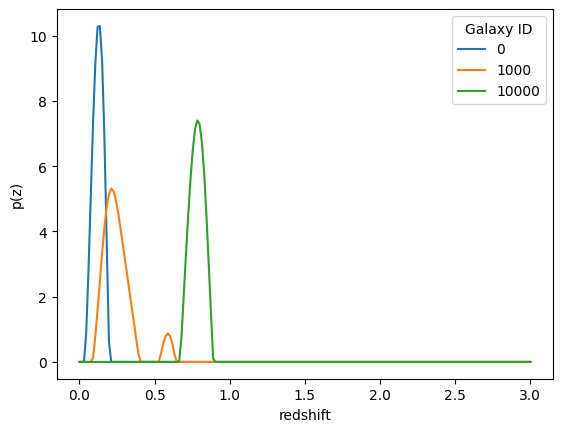

In [21]:
xvals = np.linspace(0,3,200) # we want to cover the whole available redshift space
plt.plot(xvals, flex_estimated["output"][0].pdf(xvals),label="0") 
plt.plot(xvals, flex_estimated["output"][1000].pdf(xvals),label="1000")
plt.plot(xvals, flex_estimated["output"][10000].pdf(xvals),label="10000")

plt.legend(loc="best", title="Galaxy ID")
plt.xlabel("redshift")
plt.ylabel("p(z)")

`FlexZBoost` doesn't automatically add "zmode" values to the ancillary dictionary of the `Ensemble`, but we can easily calculate redshift point estimates ourselves using `Ensemble` methods `.median()` or `.mode()`. Let's calculate the median for one of the galaxies, and plot it against the PDF and true redshift of galaxy 1000:

Text(0, 0.5, 'p(z)')

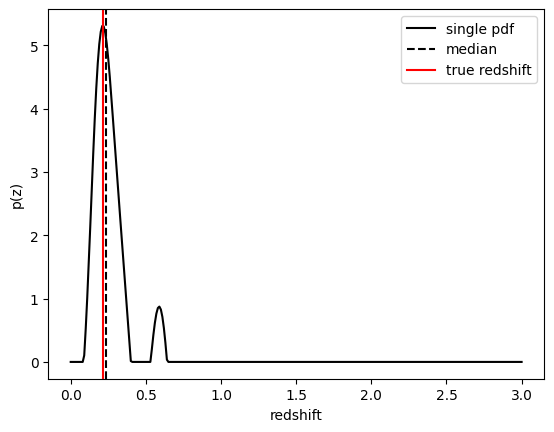

In [22]:
# calculate median of photo-z PDF
z_med = flex_estimated["output"][1000].median()

# get rest of plotting data
zgrid = np.linspace(0, 3.0, 301)
galid = 1000
truez = test_data["photometry"]["redshift"][galid]
single_gal = np.squeeze(flex_estimated["output"][galid].pdf(zgrid))

plt.plot(zgrid, single_gal, color="k", label="single pdf")
plt.axvline(z_med, color="k", ls="--", label="median")
plt.axvline(truez, color="r", label="true redshift")
plt.legend(loc="upper right")
plt.xlabel("redshift")
plt.ylabel("p(z)")

Finally, we can do this for all the galaxies, and compare the estimated redshifts with the true redshifts as for the KNN algorithm above:

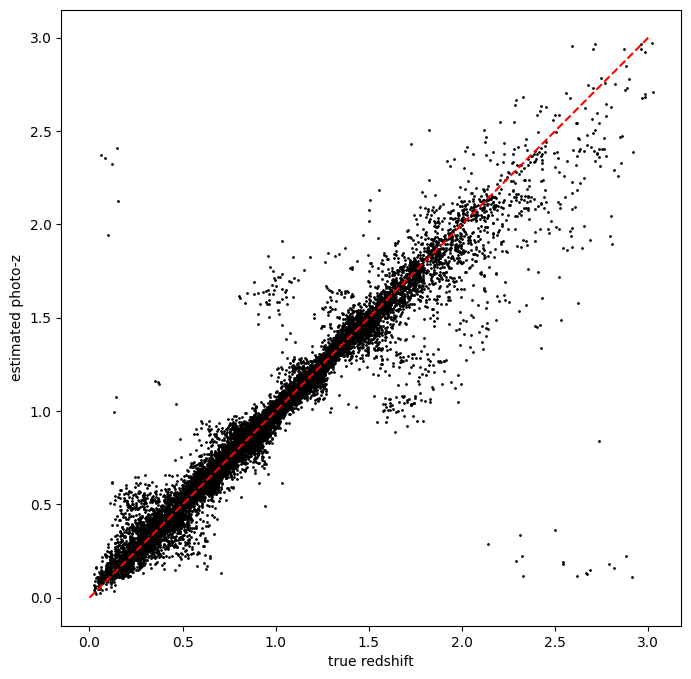

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(
    test_data["photometry"]["redshift"],
    flex_estimated["output"].median(),
    s=1,
    c="k",
    label="FlexZBoost median",
)
plt.plot([0, 3], [0, 3], "r--")
plt.xlabel("true redshift")
plt.ylabel("estimated photo-z")
plt.show()

This distribution actually looks quite similar to our distribution of KNN estimated values -- in both cases, they're quite good with some outliers at higher redshift. 

## Clean up

This step is just to remove the model file we created in Step 2:

In [18]:
import os 

os.remove("knn_model.pkl")
